## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец Date имеет тип данных object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [43]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
daily_data = data.groupby(['date','group']).agg({'user_id':'count', 'purchase':'sum', 'price': 'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
display(daily_data['date'].iloc[0], daily_data['date'].iloc[-1])
daily_data.head()


C:\Users\tatye\AppData\Local\Temp\ipykernel_12232\1097901516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


Timestamp('2021-01-02 00:00:00')

Timestamp('2021-01-24 00:00:00')

,date,group,users_count,purchase,price
0,2021-01-02,A,2854,359,29410000
1,2021-01-02,B,2861,345,29660000
2,2021-01-03,A,6596,748,62000000
3,2021-01-03,B,6619,754,65960000
4,2021-01-04,A,6566,799,64250000


Тест проводился со 2 по 24 января 2021 года. 

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [29]:
data_group = daily_data.groupby('group').agg({'users_count':'sum', 'purchase':'sum', 'price': 'sum'
})
data_group['price'] = data_group['price']/1000000
data_group

,users_count,purchase,price
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.10


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [40]:
a_set = set(data['user_id'][data['group'] == 'A'])
b_set = set(data['user_id'][data['group'] == 'B'])
user_intersection = a_set.intersection(b_set)
len(user_intersection)


1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [42]:
data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

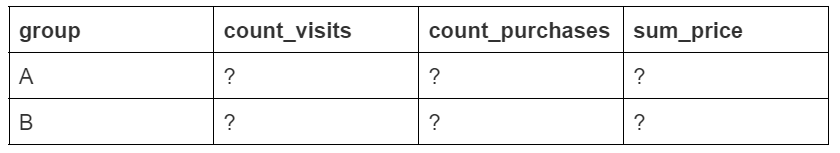
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [54]:
data_group = data.groupby('group').agg({'user_id':'count', 'purchase':'sum', 'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
data_group




,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество визитов среди групп А и В очень близко. Отличается всего на 74 человека, что не составляет и десятой доли процента. Если судить только по количеству, то можно говорить о сбалансированности выборок. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [157]:
data_group['conversion'] = data_group['count_purchases']/data_group['count_visits']*100
data_group['mean_check'] = data_group['sum_price']/ data_group['count_purchases']
data_group


,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Конверсия в группе А немного выше, чем в группе В, однако средний чек в группе А ниже на 7,5 тысяч рублей, что существенно. А так как цель компании - повысить прибыль, то метрика среднего чека более существенна в текущем исследовании и вариант В кажется более предпочтительным. 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [79]:
piv = data[data['price']!=0].pivot_table(values = 'purchase', index = 'group', columns = 'price', aggfunc = 'sum')
piv

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

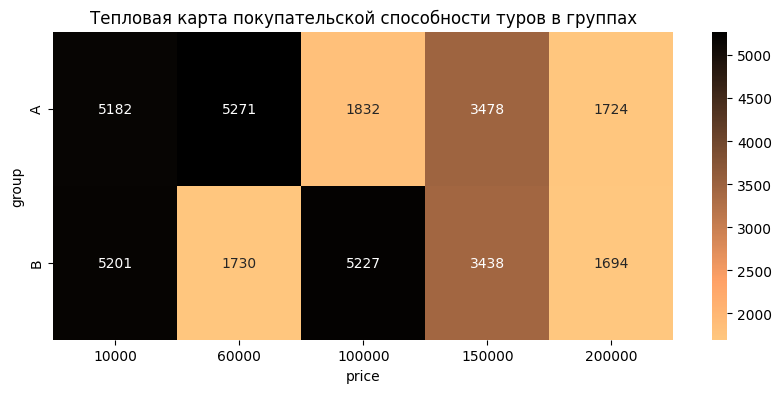

In [138]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(piv, fmt='g', annot=True, cmap='copper_r')
ax.set_title('Тепловая карта покупательской способности туров в группах')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

В группе А больше всего туров было продано по 10000 и по 60000 за тур (в Санкт-Петербург и Турцию), Турция - лидер продаж. В группе В так же один из двух лидеров продаж Санкт-Петербург, но на 1 месте Тайланд стоимостью 100 тысяч рублей за тур. 
 Количество проданных туров в группах почти идентично по трем направлениям (Санкт-Петербург, Мальдивы, Камчатка). Но в группе А лидером является Турция, а в группе В - Тайланд, который дороже на 40 тысяч, при этом в группе А Тайланд на предпоследнем месте, а в группе В аналогичное место занимает Турция.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

2    11.34
3    11.39
Name: conversion, dtype: float64

2    82888.0
3    87480.0
Name: mean_check, dtype: float64

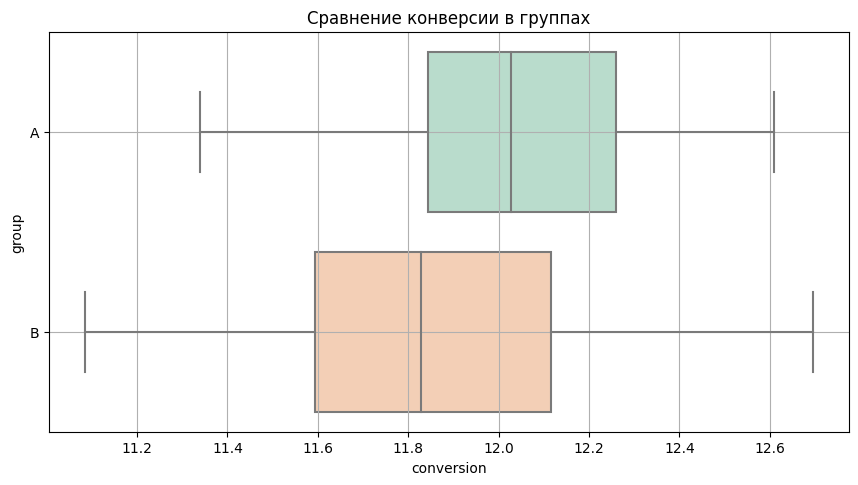

In [170]:
daily_data_group = data.groupby(['date','group']).agg({'user_id':'count', 'purchase':'sum', 'price': 'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
daily_data_group['conversion'] = daily_data_group['count_purchases']/daily_data_group['count_visits']*100
daily_data_group['mean_check'] = daily_data_group['sum_price']/ daily_data_group['count_purchases']
display(round(daily_data_group['conversion'][daily_data_group['date'] == '2021-01-03'],2))
display(round(daily_data_group['mean_check'][daily_data_group['date'] == '2021-01-03']))

#дополнительно для визуального сравнения распределения конверсий построим коробчатые даиграммы.
fig = plt.figure(figsize=(8, 4)) 
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data_group, x='conversion', y='group', palette='Pastel2', ax=ax) 
ax.set_title('Сравнение конверсии в группах')
ax.grid(True)

Медианное значение ежедневной конверсии в группе А выше, чем в группе B. Разброс конверсии в группе B несколько больше, чем в группе A. Но разница составляет около 1%, а средний чек в группе В, как мы знаем, выше. Нужны статистические тесты. Чтобы их можно было проводить, проверим данные на стабильность метрик, для этого создадим кумулятивные метрики.

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [196]:

# вычисляем кумулятивное количество посещений страницы
daily_data_group['cum_users_count'] = daily_data_group.groupby('group')['count_visits'].cumsum()
# вычисляем кумулятивное количество покупок
daily_data_group['cum_purchases'] = daily_data_group.groupby('group')['count_purchases'].cumsum()
# вычисляем кумулятивную сумму покупок
daily_data_group['cum_sum_price'] = daily_data_group.groupby('group')['sum_price'].cumsum()
# вычисляем кумулятивную конверсию
daily_data_group['cum_conversion'] = daily_data_group['cum_purchases']/daily_data_group['cum_users_count'] * 100
# вычисляем кумулятивный средний чек
daily_data_group['cum_mean_check'] = daily_data_group['cum_sum_price']/daily_data_group['cum_purchases']
display(daily_data_group[['cum_conversion', 'group']][daily_data_group['date'] == '2021-01-20'].round(2))
display(daily_data_group[['cum_mean_check', 'group']][daily_data_group['date'] == '2021-01-12'].round())
display(daily_data_group.head())



,cum_conversion,group
36,11.98,A
37,11.90,B


,cum_mean_check,group
20,81492.0,A
21,88352.0,B


,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_users_count,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

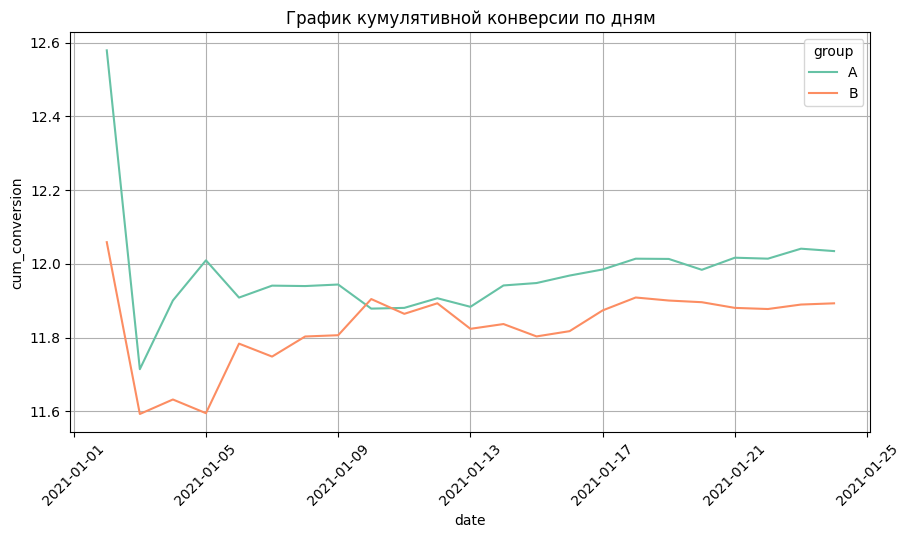

In [185]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data_group, hue='group', palette='Set2', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

До 2021-01-10 конверсия была нестабильна, но после 2021-01-12 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 
На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [201]:
# сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу count purchases) 
# и общее количество наблюдений
data_piv = daily_data_group.groupby('group').agg({'count_purchases':'sum', 'count_visits':'sum'}).reset_index()
display(data_piv)
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count= data_piv['count_purchases'], #число "успехов"
    nobs= data_piv['count_visits'], #общее число наблюдений
    alternative='larger')
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


,group,count_purchases,count_visits
0,A,17487,145307
1,B,17290,145381


p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Согласно проведенному статистическому тесту при заданном уровне значимости альфа, равном 0,05, статистическая разница между конверсиями групп А и В отсутствует.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [214]:
#Для удобства создадим отдельные таблицы для каждой из групп пользователей:
#фильтруем данные группы А
display(data_piv)
a_data = data_piv[data_piv['group'] == 'A']
#фильтруем данные группы B
b_data = data_piv[data_piv['group'] == 'B']

#объявим функцию proportions_conf_interval(). У данной функции будет три аргумента: 
# n — размер выборки, x_p — выборочная пропорция и gamma — уровень надёжности (по умолчанию он равен 0.95).
# Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % 
# и округлённых до второго знака после запятой.
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

n_a = a_data['count_visits'].values[0] # размер выборки группы A
x_p_a = (a_data['count_purchases']/a_data['count_visits']).values[0] # выборочная пропорция группы A
n_b = b_data['count_visits'].values[0] # размер выборки группы B
x_p_b = (b_data['count_purchases']/b_data['count_visits']).values[0] # выборочная пропорция группы B

conf_interval_a = proportions_conf_interval(n_a,x_p_a)
conf_interval_b = proportions_conf_interval(n_b, x_p_b)

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

#зададим функцию для создания разницы доверительных интервалов двух групп:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [n_a, n_b]
# выборочная пропорция групп A и B
xp = [x_p_a, x_p_b]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))


,group,count_purchases,count_visits
0,A,17487,145307
1,B,17290,145381


Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Доверительные интервалы конверсий А и В перекрываются, интервал их разницы проходит через точку 0. 
Значит истинная разница в конверсии  может быть как положительной, так и отрицательной. 
То есть варианты А и B равнозначны по метрике конверсии. 

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

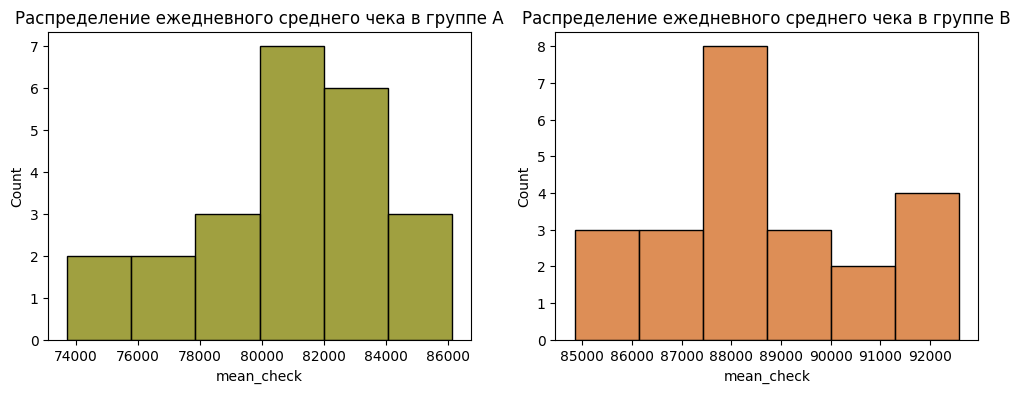

In [227]:
daily_data_group.head()
#Построим гистограмму ежедневного среднего чека в каждой из групп:

#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму 
sns.histplot(x=daily_data_group['mean_check'][daily_data_group['group']=='A'], data=daily_data_group,color='olive', ax=axes[0])
sns.histplot(x=daily_data_group['mean_check'][daily_data_group['group']=='B'], data=daily_data_group,color ='chocolate', ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение ежедневного среднего чека в группе А');
axes[1].set_title('Распределение ежедневного среднего чека в группе B');

Гистограммы напоминают нормальное распределение. Проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Нулевая гипотеза будет звучать так: распределения ежедневного среднего чека в обеих группах нормальные. Альтернативная гипотеза будет звучать так: распределение ежедневного среднего чека в одной из групп отлично от нормального. 

In [228]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения ежедневного среднего чека в обеих группах нормальные'
H1 = 'Распределение ежедневного среднего чека в одной из групп отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_group['mean_check'][daily_data_group['group']=='A'])
shapiro_result_b = shapiro(daily_data_group['mean_check'][daily_data_group['group']=='B'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения ежедневного среднего чека в обеих группах нормальные


Распределение в обеих группах нормальное, а значит, мы можем пользоваться параметрическими тестами. Воспользуемся Т-тестом для того, чтобы сравнить ежедневный средний чек в группах.

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [231]:
#Выдвигаем нулевую гипотезу:
H0 = 'Ежедневные средние чеки в группах А и B равны'
#При левосторонней альтернативной гипотезе:
H1 = 'Eжедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
 
daily_data_a = daily_data_group[daily_data_group['group'] == 'A']
daily_data_b = daily_data_group[daily_data_group['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(                                                                                            
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
  
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Eжедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Итак, в результате проведения T-теста мы получили p-value ниже уровня значимости, а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: ежедневный средний чек в группе А меньше, чем в группе B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [235]:
display(daily_data_a.head())
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
params_a = {
    'n': daily_data_a['count_visits'].count(), # размер выборки
    'x_mean': daily_data_a['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_a['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': daily_data_b['count_visits'].count(),# размер выборки
    'x_mean': daily_data_b['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_b['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))



,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_users_count,cum_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266


Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Доверительные интервалы для ежедневных средних чеков групп А и В не имеют пересечений, истинная разница между ними положительна. А это значит, что с надежностью 95% средний чек группы В больше , чем группы А.

Мы провели исследование двух вариантов посадочной страницы для продажи туров и получили следующие результаты:
несмотря на то, что конверсии в обоих вариантах не имеют статистического различия, ежедневный средний чек варианта В выше, чем варианта А. Это в первую очередь произошло из-за изменения покупательской способности в группе Б: пользователи этой версии страницы больше покупали Тайланд, в то время как пользователи страницы варианта А выбирали более дешевую Турцию.
Исходя из проведенного исследования вариант посадочной страницы В наиболее предпочтителен. 